In [2]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import argparse
import os
import time
from pathlib import Path

import voice_cloning

from voice_cloning.encoder.inference import load_model as load_speaker_encoder

from fastspeech2.dataset import Dataset
from fastspeech2.optimizer import ScheduledOptim
from fastspeech2.hparams import HyperParameters as hp
import fastspeech2.utils as utils
from fastspeech2.audio import tools as audiotools
from voice_cloning.encoder import params_data

/home/rokas/year4/mlp/cw3/Real-Time-Voice-Cloning/voice_cloning/encoder/audio.py:13: UserWarning: Unable to import 'webrtcvad'. This package enables noise removal and is recommended.
  warn("Unable to import 'webrtcvad'. This package enables noise removal and is recommended.")


In [3]:
# Get device
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')

# Get dataset
dataset = Dataset("train.txt")
loader = DataLoader(dataset, batch_size=128, shuffle=True,
                    collate_fn=dataset.collate_fn, drop_last=True, 
                    num_workers=4)

speaker_encoder = None
if hp.speaker_encoder_path != "":
    speaker_encoder = load_speaker_encoder(Path(hp.speaker_encoder_path), device).to(device)
    if not hp.train_speaker_encoder:
        for param in speaker_encoder.parameters():
            param.requires_grad = False

# Define model
model = speaker_encoder.to(device).eval()

Loaded encoder "pretrained.pt" trained to step 1564501


In [53]:
speaker_embeddings = {}
total = 0
limit = 1000

for i, batchs in enumerate(loader):
    for j, data_of_batch in enumerate(batchs):
        # Get Data
        text = torch.from_numpy(data_of_batch["text"]).long().to(device)
        mel_target = torch.from_numpy(data_of_batch["mel_target"]).float().to(device)
        D = torch.from_numpy(data_of_batch["D"]).long().to(device)
        log_D = torch.from_numpy(data_of_batch["log_D"]).float().to(device)
        f0 = torch.from_numpy(data_of_batch["f0"]).float().to(device)
        energy = torch.from_numpy(data_of_batch["energy"]).float().to(device)
        src_len = torch.from_numpy(data_of_batch["src_len"]).long().to(device)
        mel_len = torch.from_numpy(data_of_batch["mel_len"]).long().to(device)
        max_src_len = np.max(data_of_batch["src_len"]).astype(np.int32)
        max_mel_len = np.max(data_of_batch["mel_len"]).astype(np.int32)

        embeddings = model(mel_target[:, :, :params_data.mel_n_channels])
        for i in range(len(embeddings)):
            speaker = data_of_batch["id"][i].split("_")[0][1:]
            embedding = embeddings[i].cpu().numpy()
            if speaker in speaker_embeddings.keys():
                speaker_embeddings[speaker].append(embedding)
            else:
                speaker_embeddings[speaker] = [embedding]
                
        total += len(embeddings)
        if total > limit:
            break  
    if total > limit:
            break

In [66]:
num_speakers = len(speaker_embeddings.keys())
print("Number of speakers found: {}".format(num_speakers))
print("{:.2f} samples on average per speaker".format(limit/num_speakers))

Number of speakers found: 108
9.26 samples on average per speaker


In [67]:
speaker_avg = np.zeros((num_speakers, 256))
avg = 0
for i, key in enumerate(speaker_embeddings.keys()):
    arr = np.array(speaker_embeddings[key])
    mean = np.mean(arr, axis=0) 
    speaker_avg[i] = mean

[Text(0, 0, '308'),
 Text(0, 0, '247'),
 Text(0, 0, '270'),
 Text(0, 0, '248'),
 Text(0, 0, '272'),
 Text(0, 0, '259'),
 Text(0, 0, '278'),
 Text(0, 0, '241'),
 Text(0, 0, '274'),
 Text(0, 0, '262'),
 Text(0, 0, '285'),
 Text(0, 0, '299'),
 Text(0, 0, '266'),
 Text(0, 0, '263'),
 Text(0, 0, '335')]

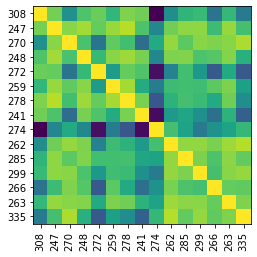

In [68]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity as sim

similarity = sim(speaker_avg, speaker_avg)  
n = 15
labels = list(speaker_embeddings.keys())[:n]

fig, ax = plt.subplots(1,1)
ax.imshow(similarity[:n, :n])
plt.xticks(np.arange(0, n))
plt.yticks(np.arange(0, n))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_yticklabels(labels)

In [69]:
single_similarity = np.zeros((num_speakers, num_speakers))
for i, key in enumerate(speaker_embeddings.keys()):
    idx = np.random.randint(len(speaker_embeddings[key]))
    emb = speaker_embeddings[key][idx]
    single_similarity[i] = sim(emb.reshape(1, -1), speaker_avg)

[Text(0, 0, '308'),
 Text(0, 0, '247'),
 Text(0, 0, '270'),
 Text(0, 0, '248'),
 Text(0, 0, '272'),
 Text(0, 0, '259'),
 Text(0, 0, '278'),
 Text(0, 0, '241'),
 Text(0, 0, '274'),
 Text(0, 0, '262')]

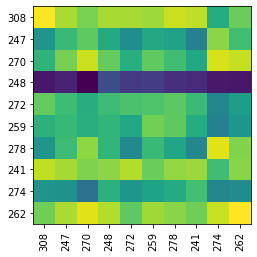

In [70]:
n = 10
fig, ax = plt.subplots(1,1)
ax.imshow(single_similarity[:n, :n])
plt.xticks(np.arange(0, n))
plt.yticks(np.arange(0, n))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_yticklabels(labels)